In [ ]:
# Importing necessary packages
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, Dense
from keras.models import Model
from transformers import AutoTokenizer, FlaubertWithLMHeadModel

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
!pip install sacremoses
!pip install openprompt
!pip install openprompt
from openprompt.prompts import ManualTemplate
from openprompt.plms import load_plm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [ ]:
df8=pd.read_csv('/content/MLMA_FR.csv')
df8.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,rt @user personnage ainsi q tte la clique gauc...,abusive,direct,shock,origin,other
1,2,@user @user @user bah oui t'as raison l'autre ...,offensive,indirect,shock,other,individual
2,3,moi j'ai personne à qui m'adresser pour réclam...,hateful,direct,anger_confusion_sadness_fear_disgust,other,women
3,4,@user @user c...est vrai que les anchois sont ...,normal,indirect,indifference,other,other
4,5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent


In [ ]:
df8 = df8[df8['sentiment'].isin(['offensive', 'normal'])]
df8['sentiment'] = df8['sentiment'].replace({'offensive': 1, 'normal': 0})

X= df8['tweet']
y=df8['sentiment']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=1, shuffle=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

X_train_tokens =tokenizer(X_train.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)
X_test_tokens =tokenizer(X_test.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
bert = TFBertModel.from_pretrained("bert-base-multilingual-cased")
Length = 100
def get_model():
    input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
    embeddings = bert([input_ids, input_mask])[1]
    out = Dropout(0.2)(embeddings)
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)
    y = Dense(1,activation = 'sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model
MBmodel = get_model()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
history = MBmodel.fit(x = {'input_ids':X_train_tokens['input_ids'],
                         'input_mask':X_train_tokens['attention_mask']},
                    y = y_train,
                    epochs=10,
                    validation_split = 0.1,
                    batch_size = 32)

Epoch 1/10
49/49 [==============================] - 113s 788ms/step - loss: 0.6390 - accuracy: 0.6327 - val_loss: 0.6110 - val_accuracy: 0.6763
Epoch 2/10
49/49 [==============================] - 33s 679ms/step - loss: 0.5439 - accuracy: 0.7165 - val_loss: 0.5380 - val_accuracy: 0.7168
Epoch 3/10
49/49 [==============================] - 33s 670ms/step - loss: 0.4497 - accuracy: 0.7835 - val_loss: 0.5588 - val_accuracy: 0.7168
Epoch 4/10
49/49 [==============================] - 33s 671ms/step - loss: 0.3791 - accuracy: 0.8383 - val_loss: 0.5509 - val_accuracy: 0.7399
Epoch 5/10
49/49 [==============================] - 33s 674ms/step - loss: 0.2913 - accuracy: 0.8827 - val_loss: 0.8047 - val_accuracy: 0.6069
Epoch 6/10
49/49 [==============================] - 33s 669ms/step - loss: 0.2195 - accuracy: 0.9182 - val_loss: 0.8365 - val_accuracy: 0.7225
Epoch 7/10
49/49 [==============================] - 33s 674ms/step - loss: 0.1679 - accuracy: 0.9452 - val_loss: 0.7452 - val_accuracy: 0.739

In [ ]:
predicted_lbl = np.where(MBmodel.predict({'input_ids':X_test_tokens['input_ids'],'input_mask':X_test_tokens['attention_mask']}) >=0.5,1,0)
accuracy = accuracy_score(y_test, predicted_lbl)
print("Accuracy of MLMA_FR on MBert Model: ",accuracy)

14/14 [==============================] - 6s 215ms/step
Accuracy of MLMA_FR on MBert Model:  0.7268518518518519


In [ ]:
df9=pd.read_csv('/content/MLMA_AR.csv')
df9.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,hateful_normal,indirect,shock,gender,individual
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,offensive,indirect,anger_confusion_sadness_indifference_disgust,other,other
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,offensive,indirect,indifference,other,individual
3,4,@user @user انا اوافقك بخصوص السوريين و العراق...,normal,direct,indifference,origin,other
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير...,normal,indirect,indifference,origin,other


In [ ]:
df9 = df9[df9['sentiment'].isin(['offensive', 'normal'])]
df9['sentiment'] = df9['sentiment'].replace({'offensive': 1, 'normal': 0})
X= df9['tweet']
y=df9['sentiment']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=1, shuffle=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

X_train_tokens =tokenizer(X_train.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)
X_test_tokens =tokenizer(X_test.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)


<ipython-input-45-7fe21112c21a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sentiment'] = df9['sentiment'].replace({'offensive': 1, 'normal': 0})


In [ ]:
history = MBmodel.fit(x = {'input_ids':X_train_tokens['input_ids'],
                         'input_mask':X_train_tokens['attention_mask']},
                    y = y_train,
                    epochs=10,
                    validation_split = 0.1,
                    batch_size = 32)

Epoch 1/10
42/42 [==============================] - 27s 634ms/step - loss: 0.1492 - accuracy: 0.9501 - val_loss: 1.2844 - val_accuracy: 0.7200
Epoch 2/10
42/42 [==============================] - 27s 652ms/step - loss: 0.0373 - accuracy: 0.9873 - val_loss: 1.4796 - val_accuracy: 0.6867
Epoch 3/10
42/42 [==============================] - 28s 676ms/step - loss: 0.0293 - accuracy: 0.9918 - val_loss: 1.5314 - val_accuracy: 0.6733
Epoch 4/10
42/42 [==============================] - 28s 656ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 1.4350 - val_accuracy: 0.7200
Epoch 5/10
42/42 [==============================] - 28s 664ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 1.5734 - val_accuracy: 0.7200
Epoch 6/10
42/42 [==============================] - 28s 676ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 1.5754 - val_accuracy: 0.7067
Epoch 7/10
42/42 [==============================] - 28s 667ms/step - loss: 0.0141 - accuracy: 0.9963 - val_loss: 1.6753 - val_accuracy: 0.7200

In [ ]:
predicted_lbl = np.where(MBmodel.predict({'input_ids':X_test_tokens['input_ids'],'input_mask':X_test_tokens['attention_mask']}) >=0.5,1,0)
accuracy = accuracy_score(y_test, predicted_lbl)
print("Accuracy of MLMA_AR on MBert Model: ",accuracy)

12/12 [==============================] - 3s 207ms/step
Accuracy of MLMA_AR on MBert Model:  0.6648793565683646


In [ ]:
df10=pd.read_csv('MLMA_DAN.csv')
df10.head()

,Unnamed: 0,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,0,1,"ring til min søster, en pige, der stadig holde...",offensive,indirect,confusion_disgust,origin,gay
1,1,2,@bruger @bruger legit nilas retarderet idk,offensive_disrespectful,indirect,anger_confusion,disability,special_needs
2,2,3,sagde retard @url,fearful_abusive_offensive_hateful,indirect,confusion_disgust,disability,special_needs
3,3,4,Amerika endnu 8 år Obamas ideologi via Hillary...,fearful_abusive_hateful_disrespectful_normal,indirect,anger_fear_shock_sadness_disgust,origin,other
4,4,5,@bruger don... fik fanden til at græde.,offensive,indirect,shock_disgust,gender,women


In [ ]:
df10 = df10[df10['sentiment'].isin(['offensive', 'normal'])]
df10['sentiment'] = df10['sentiment'].replace({'offensive': 1, 'normal': 0})
X= df10['tweet']
y=df10['sentiment']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=1, shuffle=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

X_train_tokens =tokenizer(X_train.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)
X_test_tokens =tokenizer(X_test.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)


In [ ]:
history = MBmodel.fit(x = {'input_ids':X_train_tokens['input_ids'],
                         'input_mask':X_train_tokens['attention_mask']},
                    y = y_train,
                    epochs=10,
                    validation_split = 0.1,
                    batch_size = 32)

Epoch 1/10
34/34 [==============================] - 22s 648ms/step - loss: 0.0752 - accuracy: 0.9694 - val_loss: 1.1895 - val_accuracy: 0.7917
Epoch 2/10
34/34 [==============================] - 22s 663ms/step - loss: 0.0566 - accuracy: 0.9842 - val_loss: 1.2302 - val_accuracy: 0.7333
Epoch 3/10
34/34 [==============================] - 22s 654ms/step - loss: 0.0222 - accuracy: 0.9954 - val_loss: 1.4690 - val_accuracy: 0.7167
Epoch 4/10
34/34 [==============================] - 22s 656ms/step - loss: 0.0186 - accuracy: 0.9954 - val_loss: 1.4440 - val_accuracy: 0.7500
Epoch 5/10
34/34 [==============================] - 22s 655ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 1.4659 - val_accuracy: 0.7667
Epoch 6/10
34/34 [==============================] - 23s 671ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 1.4570 - val_accuracy: 0.7667
Epoch 7/10
34/34 [==============================] - 23s 673ms/step - loss: 0.0093 - accuracy: 0.9972 - val_loss: 1.4783 - val_accuracy: 0.7667

In [ ]:
predicted_lbl = np.where(MBmodel.predict({'input_ids':X_test_tokens['input_ids'],'input_mask':X_test_tokens['attention_mask']}) >=0.5,1,0)
accuracy = accuracy_score(y_test, predicted_lbl)
print("Accuracy of MLMA_DAN on MBert Model: ",accuracy)

10/10 [==============================] - 2s 204ms/step
Accuracy of MLMA_DAN on MBert Model:  0.8233333333333334


**Testing the above trained model using the test dataset of the french language.**

In [ ]:
df11=pd.read_csv('MLMA_FR1.csv')
df11.head()

,Unnamed: 0,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,0,4481,Une serveuse de 19 ans raconte son arrestation...,offensive_hateful,indirect,sadness_shock,gender,gay
1,1,4482,je pense que ce pourrait être un pays de merde...,fearful_offensive_hateful_disrespectful_normal,indirect,anger_sadness_shock_indifference_disgust,origin,other
2,2,4483,"deuxième fois, habituez-vous clickbaitncongrat...",offensive,indirect,sadness_indifference,origin,special_needs
3,3,4484,"@sensibilité de l'utilisateur, qu'est-ce qui v...",offensive,indirect,confusion_fear_shock_sadness_disgust,origin,immigrants
4,4,4485,@user @user @user @user absolument ! comme des...,offensive,indirect,sadness_indifference,origin,left_wing_people


In [ ]:
df11 = df11[df11['sentiment'].isin(['offensive', 'normal'])]
df11['sentiment'] = df11['sentiment'].replace({'offensive': 1, 'normal': 0})
X= df11['tweet']
y=df11['sentiment']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=1, shuffle=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

X_train_tokens =tokenizer(X_train.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)
X_test_tokens =tokenizer(X_test.to_list(), add_special_tokens = True, max_length = 100, truncation = True,
          padding = 'max_length', return_tensors = 'tf', return_token_type_ids = False, return_attention_mask = True, verbose = True)


In [ ]:
predicted_lbl = np.where(MBmodel.predict({'input_ids':X_test_tokens['input_ids'],'input_mask':X_test_tokens['attention_mask']}) >=0.5,1,0)
accuracy = accuracy_score(y_test, predicted_lbl)
print("Accuracy of MLMA_DAN on MBert Model: ",accuracy)

2/2 [==============================] - 0s 105ms/step
Accuracy of MLMA_DAN on MBert Model:  0.7391304347826086


In [ ]:
eval_results = MBmodel.evaluate(x={'input_ids': X_test_tokens['input_ids'],
                                   'input_mask': X_test_tokens['attention_mask']},
                                 y=y_test)
print("Test Loss:", eval_results[0])
print("Test Accuracy:", eval_results[1])

2/2 [==============================] - 0s 119ms/step - loss: 1.7454 - accuracy: 0.7391
Test Loss: 1.7454419136047363
Test Accuracy: 0.739130437374115


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predicted_lbl)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 3  6]
 [ 6 31]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, predicted_lbl))

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         9
           1       0.84      0.84      0.84        37

    accuracy                           0.74        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.74      0.74      0.74        46



2/2 [==============================] - 0s 124ms/step


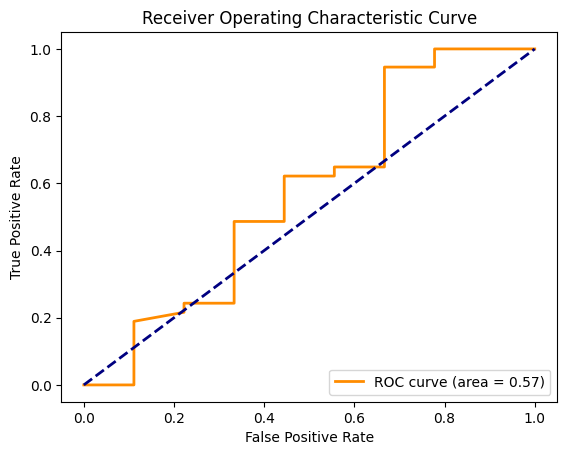

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_probs = MBmodel.predict(x={'input_ids': X_test_tokens['input_ids'],
                                   'input_mask': X_test_tokens['attention_mask']})
y_pred = (y_pred_probs > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df11['tweet']

2      deuxième fois, habituez-vous clickbaitncongrat...
3      @sensibilité de l'utilisateur, qu'est-ce qui v...
4      @user @user @user @user absolument ! comme des...
8      veux que tu saches qu'il y a un cul de pédé, u...
9      le retard doit être retardé. _ di pasir berbis...
                             ...                        
343    Je me suis fait baiser, je pense qu'ils paient...
344                            @user zorry spic espagnol
347                         @user nigga ressemble à moi.
348    @user, je dirais que je pourrais venir vivre d...
350                                  chatte absolue @url
Name: tweet, Length: 226, dtype: object

Error Analysis

In [ ]:
errors = []

for i in range(2,len(y_test)):
  if y_test[i] == predicted_lbl[i]:
    pass
  else:
    try:
      errors.append(df11['tweet'][i])  # Assuming X_test contains the sentences
    except:
      pass

print("Incorrectly predicted sentences:")
for sentence in errors:
    print(sentence)


Incorrectly predicted sentences:
La chatte de @user a bégayé suhin ?
servir le mongol ? une bière blonde ? saucisse blanche? #yaxley #lennon @url
papa douleur seins grosse chatte manger sperme lezbo public branler femme bbc jeune masturbation canada nn@url
@user je suis épicé
@user lewis pédé
au fait....connasse machado !!!! #toutlemonde @utilisateur
@user @user @user @user @user @user aqua favori spic @url


In [ ]:
d=y_test
d.tolist()

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0]